## Obtaining Data

In [1]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns

# ML Libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
data = pd.read_csv('data.csv',encoding='utf-8')
data = data.astype(str)
tweets = pd.DataFrame(data['tweet_text'])

## Scrubbing/Cleaning Data

### DataFrame treatment

In [3]:
#preview of data
data.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,nan,No emotion toward brand or product
6,nan,nan,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [4]:
#stats on data
data.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9288,9288,9288
unique,9168,10,5
top,nan,nan,No emotion toward brand or product
freq,27,5997,5389


In [5]:
# Get names of indexes for which column Age has value 30
indexNames = data[data['emotion_in_tweet_is_directed_at'] == 'nan' ].index
# Delete these row indexes from dataFrame
data.drop(indexNames , inplace=True)

data.dropna()


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9272,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion
9274,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion
9275,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion
9280,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion


In [6]:
data=data.rename(columns={'emotion_in_tweet_is_directed_at':'Brand','is_there_an_emotion_directed_at_a_brand_or_product':'Sentiment'})

In [7]:
#stats without nan in tweet column
data.describe()

,tweet_text,Brand,Sentiment
count,3291,3291,3291
unique,3281,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,Positive emotion
freq,3,946,2672


In [8]:
#Changing column info to assist with encoding later
product_dict = {"iPhone":'Apple','iPad or iPhone App': 'Apple','iPad':'Apple','nan':'none','Android':'Google','Android App':'Google','Other Google product or service':'Google','Other Apple product or service':'Apple'}
sentiment_dict = {'Negative emotion': '-1','Positive emotion':'1','No emotion toward brand or product':'0', "I can't tell": '0'}
data = data.replace({"Brand": product_dict})
data = data.replace({'Sentiment':sentiment_dict})

#data['prediction'] = (data['Brand'],data['Sentiment'])
data['prediction'] = list(zip(data.Brand, data.Sentiment))
print(len(data['Brand']))
print(len(data['Sentiment']))

3291
3291


In [9]:
data.head()

,tweet_text,Brand,Sentiment,prediction
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,-1,"(Apple, -1)"
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,1,"(Apple, 1)"
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,1,"(Apple, 1)"
3,@sxsw I hope this year's festival isn't as cra...,Apple,-1,"(Apple, -1)"
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,"(Google, 1)"


In [10]:
data.describe()

,tweet_text,Brand,Sentiment,prediction
count,3291,3291,3291,3291
unique,3281,2,3,6
top,RT @mention Marissa Mayer: Google Will Connect...,Apple,1,"(Apple, 1)"
freq,3,2409,2672,1949


### Twitter data

In [11]:
data.head(10) #preview of what data looks like
tweets = data['tweet_text']
len(tweets)

3291

In [12]:
data.describe()

,tweet_text,Brand,Sentiment,prediction
count,3291,3291,3291,3291
unique,3281,2,3,6
top,RT @mention Marissa Mayer: Google Will Connect...,Apple,1,"(Apple, 1)"
freq,3,2409,2672,1949


In [13]:
import re
from string import punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
stopword_list = stopwords.words('english')
stopword_list.append([',','rt','mention','link'])
for tweet in tweets:
    tweet = re.sub('[^a-zA-Z]', ' ', tweet)
    tweet = tweet.join([c for c in tweet if c not in punctuation])
    tweet = tweet.lower()
    tweet = tweet.split()
    ps = PorterStemmer()
    tweet = [ps.stem(word) for word in tweet if not word in stopword_list]
    tweet = ' '.join(tweet)
    corpus.append(tweet)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jamaalsmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
data['tweet_text'] = corpus #so that dataframe has cleaned tweets

In [45]:
#Creation of Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 3000)
X = cv.fit_transform(corpus).toarray()
y = data['Sentiment']
y1 = data['Brand']

In [31]:
##Tokenize data and then generate FreqDist
from nltk import word_tokenize
tokens = word_tokenize(','.join(map(str,corpus)))

In [32]:
#FreqDist
from nltk import FreqDist
freq = FreqDist(tokens)
most_used_words = freq.most_common(100)
most_used_words = pd.DataFrame(most_used_words, columns=['word','count'])
most_used_words.reset_index(drop=True,inplace=True)


## Exploratory Data Analysis

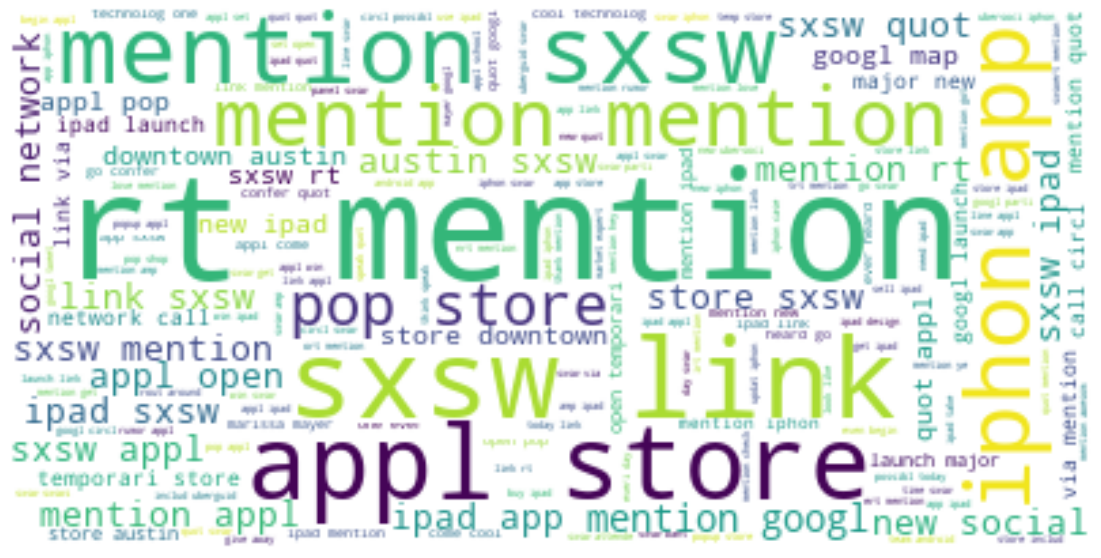

In [33]:
#Wordcloud of popular words
text = " ".join(tweet for tweet in data.tweet_text)
plt.figure(figsize=(35,10))
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["mention", "link", "rt",])

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Based on the wordcloud,it appears that the tweets reviewed were taken at a SXSW event in Austin, TX. Further, there is specific mention of the words ipad, apple store and launch. When I Googled ipad product launches at SXSW, I learned that Apple launched its iPad2 product at the 2011 event. 

With the knowledge that these tweets were centered around the SXSW festival, I then noticed that what appeared to be two sets of names were in the top twenty list. One name appears to be Marissa Mayer and the other was Tim Reilli. I performed another Google and [found information about the following event in 2011.](https://www.mediabullseye.com/2011/03/sxsw-update-chasing-the-ideas-of-innovation/) This information further assists us with learning about our the author of the tweets we are reviewing because both presenters spoke to advances that their respective organizations had made with location based services at this forum.

I then examined the events that Google had planned for the 2011 SXSW festival. I undertook this query because I noticed that Google was in the top 20 most frequently used words. During the 2011 SXSW event, [Google had a plethora of events that touched on subjects such as recommendation engines and hybrid marketing.](https://googleblog.blogspot.com/2011/03/google-at-sxsw-2011-austin-here-we-come.html) Based on this quick research, one can assume that tweets related to Google will be commenting on the new technologies the firm was presenting at this conference.


Finally, it is worth noting some initial impressions about the tweet's larger context. After reading some of the tweets before preprocessing, I noticed that some of the tweets related to Apple appeared to be focused on the user experience people were having with apple products at SXSW. I then noticed that like Google, at this time, Apple was launching its iPad2. Thus, it is safe to assume that tweets would be a good reflection the sentiment that festival goers had related to these launches.

***

This analyis will not simply report back whether more individuals favored one company to another. Instead, its findings can provide insight into how users of their product's found their latest offerings when first presented with them at a technology conference. 


Text(0.5, 1.0, 'Top 10 Words')

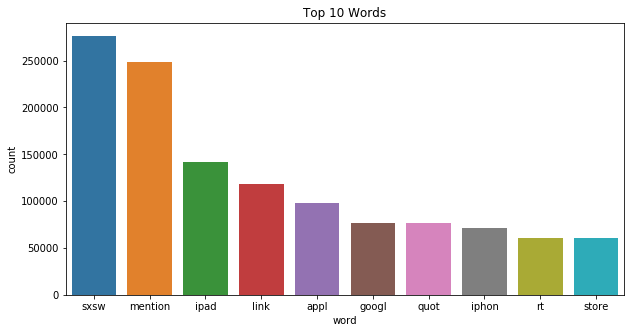

In [34]:
#top 10 words
top10_words = most_used_words[:10]
top10_words.head()

plt.figure(figsize=(10,5))
sns.barplot(x='word',y='count',data=top10_words)
plt.title('Top 10 Words')

### Popularity of the Two Brands

Text(0.5, 0, 'Company')

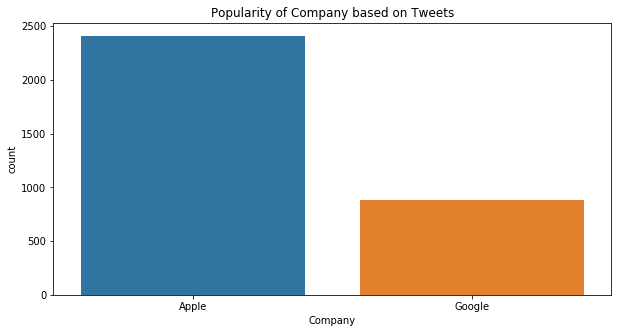

In [35]:
#Count of how many times each Brand is mentioned
plt.figure(figsize=(10,5))
sns.countplot(x="Brand",data=data)
plt.title('Popularity of Company based on Tweets')
plt.xlabel('Company')

Despite only having two inputs (Apple & Other Apple product or service) when compared to Google that had four inputs (Google,Android, Android App, Other Google product or service), Apple was discussed more in the tweets according to the data.

One might conclude that the launch of the iPad2 was a major event that Apple marketed well and built suspense amongst the tech community.

Text(0.5, 1.0, 'Attendee Sentiment Expressed in Tweets')

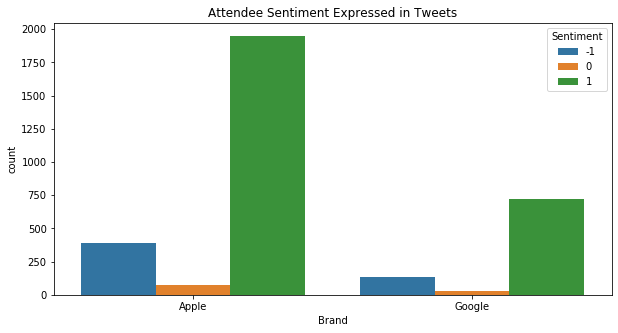

In [36]:
#Sentiment distribution for each Brand
plt.figure(figsize=(10,5))
sns.countplot(x='Brand',hue='Sentiment',data=data)
plt.title('Attendee Sentiment Expressed in Tweets')

In [37]:
#from textblob import textblob
#data['polarity'] = data['tweet_text'].map(lambda text: TextBlob(text).sentiment.polarity)
data['review_len'] = data['tweet_text'].astype(str).apply(len)
data['word_count'] = data['tweet_text'].apply(lambda x: len(str(x).split()))

In [38]:
data.head()

,tweet_text,Brand,Sentiment,prediction,review_len,word_count
0,wesley g iphon hr tweet rise austin dead need ...,Apple,-1,"(Apple, -1)",9285,1682
1,jessede know fludapp awesom ipad iphon app lik...,Apple,1,"(Apple, 1)",11967,2070
2,swonderlin wait ipad also sale sxsw swonderlin...,Apple,1,"(Apple, 1)",2861,495
3,sxsw hope year festiv crashi year iphon app sx...,Apple,-1,"(Apple, -1)",4017,729
4,sxtxstate great stuff fri sxsw marissa mayer g...,Google,1,"(Google, 1)",14145,2263


Text(0.5, 1.0, 'Length of Tweets by Brand')

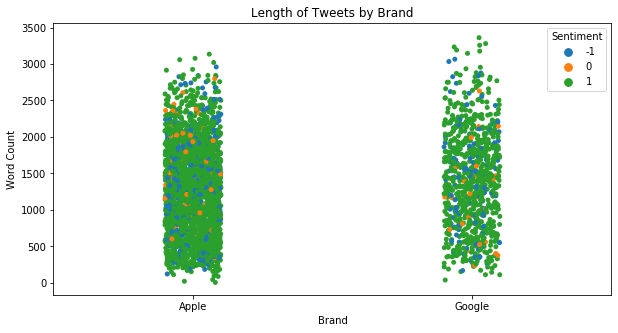

In [39]:
#review length compared against tweets
plt.figure(figsize=(10,5))
sns.stripplot(x='Brand',y='word_count',hue='Sentiment',data=data)
plt.xlabel('Brand')
plt.ylabel('Word Count')
plt.title('Length of Tweets by Brand')

In [40]:
#Average length of tweets by Brand
brand_length = data.groupby(['Brand','Sentiment']).mean()
brand_length.round(decimals=2)

data.describe()

,review_len,word_count
count,3291.000000,3291.000000
mean,7952.615618,1337.426922
std,3754.438144,632.980208
min,47.000000,6.000000
25%,5000.500000,831.500000
50%,7956.000000,1333.000000
75%,10729.000000,1792.000000
max,19975.000000,3361.000000


In [41]:
brand_length

review_len   word_count
Brand  Sentiment                          
Apple  -1         7947.592784  1326.672680
       0          8094.222222  1378.375000
       1          7616.916367  1299.615187
Google -1         9032.931298  1472.816794
       0          7220.964286  1185.607143
       1          8678.751037  1422.398340

## Modeling

### Final Pre-Processing

In [42]:
#Encoding
from sklearn.preprocessing import OneHotEncoder

oe = OneHotEncoder()
oe.fit(X)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

### Naive Bayes Model

In [47]:
#splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [55]:
#training Naive Bayes for sentiment
from sklearn.naive_bayes import GaussianNB
classifier_sentiment = GaussianNB()
classifier_sentiment.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [56]:
#splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size = 0.20, random_state = 0)

In [57]:
#training Naive Bayes for Brand
from sklearn.naive_bayes import GaussianNB
classifier_brand = GaussianNB()
classifier_brand.fit(X_train, y1_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [58]:
#predictions
y_pred_sentiment = classifier_sentiment.predict(X_test)
y_pred_brand = classifier_brand.predict(X_test)

In [59]:
#evaluation of sentiment model
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_sentiment)
print(cm)
accuracy_score(y_test, y_pred)

[[ 55   5  42]
 [  5   1  11]
 [126  23 391]]


0.6783004552352049

The Accuracy Score for this model is 0.6783004552352049


Text(0.5, 1, 'Confusion Matrix')

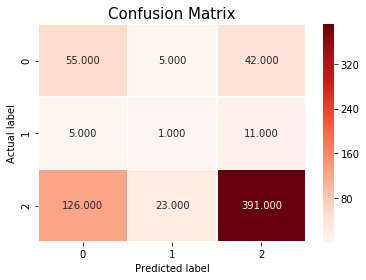

In [60]:
#confusion matrix visual for sentiment
cm = confusion_matrix(y_test,y_pred_sentiment)
acc = accuracy_score(y_test,y_pred_sentiment)
print('The Accuracy Score for this model is {acc}'.format(acc=acc))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = False, cmap = 'Reds');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
#plt.text(verticalalignment='center')
all_sample_title = 'Accuracy Score: {0}'.format(acc)
plt.title('Confusion Matrix', size = 15)

The Accuracy Score for this model is 0.7678300455235205


Text(0.5, 1, 'Confusion Matrix')

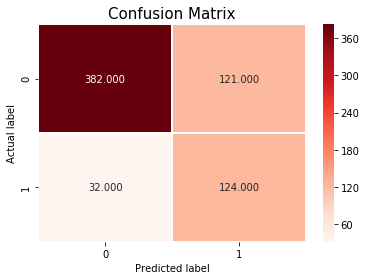

In [61]:
#confusion matrix visual for Brand
cm = confusion_matrix(y1_test,y_pred_brand)
acc = accuracy_score(y1_test,y_pred_brand)
print('The Accuracy Score for this model is {acc}'.format(acc=acc))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = False, cmap = 'Reds');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
#plt.text(verticalalignment='center')
all_sample_title = 'Accuracy Score: {0}'.format(acc)
plt.title('Confusion Matrix', size = 15)

### Recurrent Neural Network - LSTM

In [72]:
import tensorflow as tf

In [78]:
ann = tf.keras.models.Sequential()

ann.add(tf.keras.layers.Dense(units=6, activation='relu'))

ann.add(tf.keras.layers.Dense(units=6, activation='relu'))

ann.add(tf.keras.layers.Masking(mask_value=0)

#ann.add(tf.keras.layers.LSTM(64, return_sequences=False,dropout=0.1, recurrent_dropout=0.1)
        
#ann.add(tf.keras.layers.Dropout(0.5)

#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

SyntaxError: invalid syntax (<ipython-input-78-3652cda70d45>, line 15)

In [81]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [83]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

model = Sequential()

# Embedding layer
#model.add(
    #Embedding(input_dim=num_words,
              #input_length = training_length,
              #output_dim=100,
              #weights=[embedding_matrix],
              #trainable=False,
              #mask_zero=True))

# Masking layer for pre-trained embeddings
model.add(Masking(mask_value=0.0))

# Recurrent layer
model.add(LSTM(64, return_sequences=False, 
               dropout=0.1, recurrent_dropout=0.1))

# Fully connected layer
model.add(Dense(64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [86]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Create callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

In [87]:
history = model.fit(X_train,  y_train, 
                    batch_size=2048, epochs=150,
                    callbacks=callbacks,
                    validation_data=(X_test, y_test))

Epoch 1/150


TypeError: in user code:

    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:531 train_step  **
        y_pred = self(x, training=True)
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/sequential.py:291 call
        outputs = layer(inputs, **kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:111 call
        math_ops.not_equal(inputs, self.mask_value), axis=-1, keepdims=True)
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py:180 wrapper
        return target(*args, **kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:1481 not_equal
        return gen_math_ops.not_equal(x, y, name=name)
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py:6422 not_equal
        name=name)
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:479 _apply_op_helper
        repr(values), type(values).__name__, err))

    TypeError: Expected int64 passed to parameter 'y' of op 'NotEqual', got 0.0 of type 'float' instead. Error: Expected int64, got 0.0 of type 'float' instead.
